In [24]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Add
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from numpy import array

In [25]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('D:/UIT/DA_Gr07/Dataset/ADBE_Stock.csv')
df1=df.reset_index()['Close']

In [26]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [27]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [28]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [29]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [30]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
# X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
# X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
# X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

if len(X_train.shape) == 2:
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
if len(X_test.shape) == 2:
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [31]:
from tensorflow.keras.layers import RNN, SimpleRNNCell
from tensorflow.keras.initializers import glorot_uniform

class AdditiveRNNCell(SimpleRNNCell):
    def build(self, input_shape):
        super().build(input_shape)
        self.kernel = self.add_weight(shape=(input_shape[-1], self.units),
                                      initializer=glorot_uniform(),
                                      name='kernel')
        self.recurrent_kernel = self.add_weight(shape=(self.units, self.units),
                                                initializer=glorot_uniform(),
                                                name='recurrent_kernel')
        self.bias = self.add_weight(shape=(self.units,),
                                    initializer='zeros',
                                    name='bias')
        self.built = True

    def __call__(self, inputs, states, training=None):
        prev_output = states[0]
        h = prev_output + self.activation(tf.matmul(inputs, self.kernel) + tf.matmul(prev_output, self.recurrent_kernel) + self.bias)
        return h, [h]

In [32]:
# Xây dựng model AddRNN
inputs = Input(shape=(time_step, 1))
x = RNN(AdditiveRNNCell(50), return_sequences=False)(inputs)  # 50 units
outputs = Dense(1)(x)

model = Model(inputs, outputs)
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 100, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rnn_1 (RNN)                     │ (None, 50)             │         5,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,251 (20.51 KB)

 Trainable params: 5,251 (20.51 KB)

 Non-trainable params: 0 (0.00 B)

In [33]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100


c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\optimizers\base_optimizer.py:664: UserWarning: Gradients do not exist for variables ['kernel', 'recurrent_kernel', 'bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 18694.1777 - val_loss: 384.7326
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 987.4243 - val_loss: 252.0850
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 497.6107 - val_loss: 47.4079
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 189.3482 - val_loss: 116.3030
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 157.0346 - val_loss: 361.6805
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 309.8120 - val_loss: 88.0628
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 720.4142 - val_loss: 581.7209
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 6814.7319 - val_loss: 1035.1246
Epoch 9/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 2122.7234 - val_loss: 1168.9534
Epoch 10/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 840.7974 - val_loss: 632.3889
Epoch 11/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 225.7808 - val_loss: 23.8492
Epoch 12/100
13/1

In [34]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


In [35]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)

In [45]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
ytest_original = scaler.inverse_transform(ytest.reshape(-1, 1))
test_rmse = np.sqrt(np.mean((y_pred - ytest_original)**2))
print('Testing RMSE:', test_rmse)

Testing RMSE: 448.33596439405045


In [37]:
# 13. Đánh giá độ chính xác thuật toán bằng MAPE
def MAPE(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Transform yval and ytest back to original scale
ytest_original = scaler.inverse_transform(ytest.reshape(-1, 1))

# Calculate MAPE for validation and test data
test_mape = MAPE(ytest_original, y_pred)

print('Testing MAPE:', test_mape)

Testing MAPE: 60.65971009305654


In [38]:
# 13. Đánh giá độ chính xác thuật toán bằng MAE
def MAE(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

# Transform yval and ytest back to original scale
ytest_original = scaler.inverse_transform(ytest.reshape(-1, 1))

# Calculate MAE for validation and test data
test_mae = MAE(ytest_original, y_pred)

print('Testing MAE:', test_mae)

Testing MAE: 303.9736360677898


In [39]:
# Dự báo 30 ngày tiếp theo
x_input = test_data[-time_step:].reshape(1, -1)
temp_input = list(x_input[0])

lst30_output = []
n_steps = time_step
i = 0
while i < 30:
    if len(temp_input) > n_steps:
        x_input = np.array(temp_input[-n_steps:])
        x_input = x_input.reshape((1, n_steps, 1))
    else:
        x_input = np.array(temp_input).reshape((1, len(temp_input), 1))

    yhat = model.predict(x_input, verbose=0)
    temp_input.extend(yhat[0].tolist())
    lst30_output.extend(yhat.tolist())
    i += 1

# Chuyển đổi giá trị dự đoán về phạm vi ban đầu
lst30_output = scaler.inverse_transform(lst30_output)

# In giá trị dự đoán
print("Dự báo 30 ngày tiếp theo:", lst30_output)

Dự báo 30 ngày tiếp theo: [[491.67685796]
 [487.8562488 ]
 [523.46925245]
 [532.23987922]
 [468.63116943]
 [419.70218495]
 [449.76068921]
 [534.4041243 ]
 [502.77084001]
 [423.46775428]
 [355.10895493]
 [333.10368584]
 [364.93264647]
 [381.95334137]
 [263.00150822]
 [174.98438875]
 [209.90644808]
 [275.92807242]
 [236.84566805]
 [111.71849217]
 [ 89.81027616]
 [143.15946661]
 [253.13781641]
 [485.46401297]
 [731.0254861 ]
 [681.01582648]
 [470.96278262]
 [395.78459526]
 [359.39282135]
 [360.73154657]]


In [46]:
# Dự báo 60 ngày tiếp theo
x_input = test_data[-time_step:].reshape(1, -1)
temp_input = list(x_input[0])

lst60_output = []
n_steps = time_step
i = 0
while i < 60:
    if len(temp_input) > n_steps:
        x_input = np.array(temp_input[-n_steps:])
        x_input = x_input.reshape((1, n_steps, 1))
    else:
        x_input = np.array(temp_input).reshape((1, len(temp_input), 1))

    yhat = model.predict(x_input, verbose=0)
    temp_input.extend(yhat[0].tolist())
    lst60_output.extend(yhat.tolist())
    i += 1

# Chuyển đổi giá trị dự đoán về phạm vi ban đầu
lst60_output = scaler.inverse_transform(lst60_output)

# In giá trị dự đoán
print("Dự báo 60 ngày tiếp theo:", lst60_output)

Dự báo 60 ngày tiếp theo: [[491.67685796]
 [487.8562488 ]
 [523.46925245]
 [532.23987922]
 [468.63116943]
 [419.70218495]
 [449.76068921]
 [534.4041243 ]
 [502.77084001]
 [423.46775428]
 [355.10895493]
 [333.10368584]
 [364.93264647]
 [381.95334137]
 [263.00150822]
 [174.98438875]
 [209.90644808]
 [275.92807242]
 [236.84566805]
 [111.71849217]
 [ 89.81027616]
 [143.15946661]
 [253.13781641]
 [485.46401297]
 [731.0254861 ]
 [681.01582648]
 [470.96278262]
 [395.78459526]
 [359.39282135]
 [360.73154657]
 [386.42423206]
 [376.61982837]
 [354.64444413]
 [404.5648498 ]
 [569.81131338]
 [605.58340138]
 [463.97463725]
 [293.28615764]
 [180.39027156]
 [135.94786652]
 [175.37564451]
 [425.44449693]
 [842.4668811 ]
 [943.58208607]
 [625.23035799]
 [532.4261281 ]
 [640.86316789]
 [715.56253849]
 [671.57115245]
 [617.65512544]
 [548.74218657]
 [491.66315939]
 [501.49612331]
 [555.3649807 ]
 [623.43987715]
 [638.52949992]
 [593.86130105]
 [517.5086938 ]
 [441.73098716]
 [396.9900954 ]]


In [47]:
# Dự báo 90 ngày tiếp theo
x_input = test_data[-time_step:].reshape(1, -1)
temp_input = list(x_input[0])

lst90_output = []
n_steps = time_step
i = 0
while i < 90:
    if len(temp_input) > n_steps:
        x_input = np.array(temp_input[-n_steps:])
        x_input = x_input.reshape((1, n_steps, 1))
    else:
        x_input = np.array(temp_input).reshape((1, len(temp_input), 1))

    yhat = model.predict(x_input, verbose=0)
    temp_input.extend(yhat[0].tolist())
    lst90_output.extend(yhat.tolist())
    i += 1

# Chuyển đổi giá trị dự đoán về phạm vi ban đầu
lst90_output = scaler.inverse_transform(lst90_output)

# In giá trị dự đoán
print("Dự báo 90 ngày tiếp theo:", lst90_output)

Dự báo 90 ngày tiếp theo: [[ 491.67685796]
 [ 487.8562488 ]
 [ 523.46925245]
 [ 532.23987922]
 [ 468.63116943]
 [ 419.70218495]
 [ 449.76068921]
 [ 534.4041243 ]
 [ 502.77084001]
 [ 423.46775428]
 [ 355.10895493]
 [ 333.10368584]
 [ 364.93264647]
 [ 381.95334137]
 [ 263.00150822]
 [ 174.98438875]
 [ 209.90644808]
 [ 275.92807242]
 [ 236.84566805]
 [ 111.71849217]
 [  89.81027616]
 [ 143.15946661]
 [ 253.13781641]
 [ 485.46401297]
 [ 731.0254861 ]
 [ 681.01582648]
 [ 470.96278262]
 [ 395.78459526]
 [ 359.39282135]
 [ 360.73154657]
 [ 386.42423206]
 [ 376.61982837]
 [ 354.64444413]
 [ 404.5648498 ]
 [ 569.81131338]
 [ 605.58340138]
 [ 463.97463725]
 [ 293.28615764]
 [ 180.39027156]
 [ 135.94786652]
 [ 175.37564451]
 [ 425.44449693]
 [ 842.4668811 ]
 [ 943.58208607]
 [ 625.23035799]
 [ 532.4261281 ]
 [ 640.86316789]
 [ 715.56253849]
 [ 671.57115245]
 [ 617.65512544]
 [ 548.74218657]
 [ 491.66315939]
 [ 501.49612331]
 [ 555.3649807 ]
 [ 623.43987715]
 [ 638.52949992]
 [ 593.86130105]
 [ 51

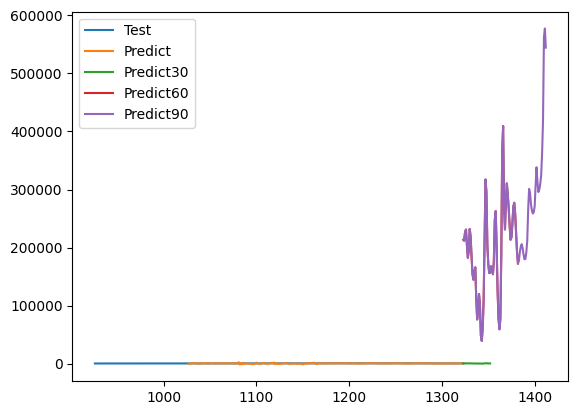

In [49]:
# 14.Vẽ hình

# train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
# plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))

prediect30_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1) +29, step=1)
plt.plot(prediect30_data_index,(lst30_output))

prediect60_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+59, step=1)
plt.plot(prediect60_data_index,scaler.inverse_transform(lst60_output))

prediect90_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+89, step=1)
plt.plot(prediect90_data_index,scaler.inverse_transform(lst90_output))

plt.legend(['Test','Predict', 'Predict30', 'Predict60', 'Predict90'])
plt.show()

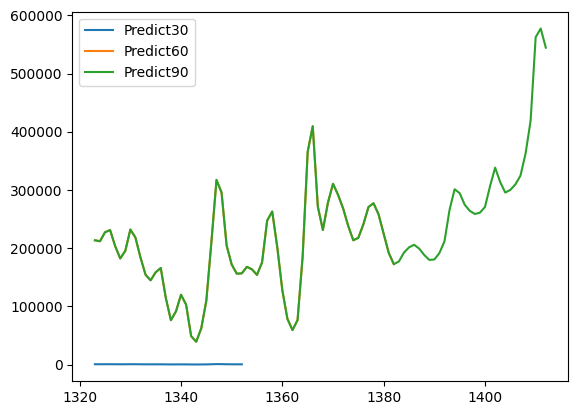

In [50]:
prediect30_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1) +29, step=1)
plt.plot(prediect30_data_index,(lst30_output))

prediect60_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+59, step=1)
plt.plot(prediect60_data_index,scaler.inverse_transform(lst60_output))

prediect90_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+89, step=1)
plt.plot(prediect90_data_index,scaler.inverse_transform(lst90_output))

plt.legend(['Predict30', 'Predict60', 'Predict90'])
plt.show()